In [1]:
import time
import random
import collections

import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as td
import torch.optim as to

import pytorch_lightning as pl

import matplotlib.pyplot as plt

torch.manual_seed(31337)
np.random.seed(31337)
random.seed(31337)

np.set_printoptions(edgeitems=100, linewidth=2000)
torch.set_printoptions(edgeitems=100, linewidth=2000)

In [2]:
def generate_hidden(k, n):
    flag = np.tile(np.random.binomial(1, 0.5, size=(n, 1, 1)), (1, k, 1))
    x = np.random.standard_normal(size=(n, k, 1))
    return x, flag


def prepare_data(x, flag, mode):
    if mode == "exp":
        y = np.where(flag > 0, np.exp(x), np.exp(-x))
    elif mode == "log":
        y = np.where(flag > 0, np.log(1 + np.exp(x)), np.log(1 + np.exp(-x)))
    else:
        raise ValueError("Unknown mode: " + mode)
    
    return np.concatenate((x, flag, x * flag, x * x), axis=2), y


def generate_data(k, n, mode):
    x, flag = generate_hidden(k, n)
    return prepare_data(x, flag, mode)

In [3]:
class Data(pl.LightningDataModule):
    
    def __init__(self, k, n_train=10000, n_val=1000, n_test=1000, mode="exp"):
        super().__init__()
        self.k = k
        self.n_train = n_train
        self.n_val = n_val
        self.n_test = n_test
        self.mode = mode
    
    def setup(self, stage=None):
        x_train, y_train = generate_data(self.k, self.n_train, self.mode)
        self.train_dataset = td.TensorDataset(
            torch.from_numpy(x_train.astype("float32")), 
            torch.from_numpy(y_train.astype("float32")),
        )
        x_val, y_val = generate_data(self.k, self.n_val, self.mode)
        self.val_dataset = td.TensorDataset(
            torch.from_numpy(x_val.astype("float32")), 
            torch.from_numpy(y_val.astype("float32")),
        )
        x_test, y_test = generate_data(self.k, self.n_test, self.mode)
        self.test_dataset = td.TensorDataset(
            torch.from_numpy(x_test.astype("float32")), 
            torch.from_numpy(y_test.astype("float32")),
        )
        
    def train_dataloader(self):
        return td.DataLoader(self.train_dataset, batch_size=100, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return td.DataLoader(self.val_dataset, batch_size=100, num_workers=4)

    def test_dataloader(self):
        return td.DataLoader(self.test_dataset, batch_size=100, shuffle=False, num_workers=4)

In [20]:
class NeuralSort(nn.Module):

    def __init__(self, n, tau):
        super(NeuralSort, self).__init__()
        self.n = n
        self.tau = tau
        
        self.one = torch.ones((n, 1), dtype=torch.float32)
        self.scaling = (n + 1 - 2 * (torch.arange(n) + 1)).type(torch.float32)
        self.softmax = torch.nn.Softmax(-1)

    def forward(self, s):
        """
            s: input elements to be sorted. Shape: batch_size x n x 1
            tau: temperature for relaxation. Scalar.
        """
        A = torch.abs(s - s.permute(0, 2, 1))
        B = torch.matmul(A, torch.matmul(self.one, torch.transpose(self.one, 0, 1)))
        
        C = torch.matmul(s, self.scaling.unsqueeze(0))
        
        P_max = (C - B).permute(0, 2, 1)
        return self.softmax(P_max / self.tau)


class Ndcg(nn.Module):
    
    def __init__(self, n, tau):
        super(Ndcg, self).__init__()
        self.sort = NeuralSort(n, tau)
        self.log1pk = torch.from_numpy(np.log2(np.arange(n) + 2)).type(torch.float32)[None, :]

    def forward(self, s, y):
        y_sorted = (y * self.sort(s)).sum(axis=1)
        # dcg = (torch.pow(2, s_sorted) - 1) / self.log1pk
        # perfect_dcg = (torch.from_numpy(np.power(2, -np.sort(-y.squeeze(2).detach().numpy(), axis=1))) - 1) / self.log1pk
        dcg = y_sorted / self.log1pk
        perfect_dcg = torch.from_numpy(-np.sort(-y.squeeze(2).detach().numpy(), axis=1)) / self.log1pk
        return dcg.sum(axis=1) / perfect_dcg.sum(axis=1)


class Ranker(pl.LightningModule):
    
    def __init__(self, n, tau, loss="ndcg"):
        super(Ranker, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(in_features=4, out_features=10, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=10, bias=True),
            nn.ReLU(),
            nn.Linear(in_features=10, out_features=1, bias=True),
        )

        self.loss = Ndcg(n, tau) if loss == "ndcg" else nn.MSELoss()
            
    def forward(self, x):
        return torch.exp(self.layers(x))

    def step(self, batch, batch_idx, metric, prog_bar=False):
        x, y = batch
        
        s = self.forward(x)

        loss = self.loss(s, y).mean()
        self.log(metric, loss, prog_bar=prog_bar)
        
        return loss

    def training_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "train_loss", True)
    
    def validation_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "val_loss")
    
    def test_step(self, batch, batch_idx):
        return self.step(batch, batch_idx, "test_loss")
        
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-4, weight_decay=1e-6)
        lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, min_lr=1e-6, patience=5, verbose=True)
        scheduler = {
            'scheduler': lr_scheduler,
            'reduce_on_plateau': True,
            'monitor': 'val_loss'
        }
        return [optimizer], [scheduler]

In [21]:
trainer = pl.Trainer(
    max_epochs=50,
    # accelerator='cpu',
    # devices=1,
    callbacks=[
        pl.callbacks.early_stopping.EarlyStopping(monitor="val_loss", patience=15),
        pl.callbacks.LearningRateMonitor(logging_interval="step"),
        pl.callbacks.ModelCheckpoint(monitor="val_loss"),
        # pl.callbacks.RichProgressBar(leave=True),
    ])

k = 10
mode = "log"
ranker = Ranker(k, 0.5)
data = Data(k, mode=mode)

trainer.fit(
    ranker, 
    data,
)

pass

GPU available: False, used: False
TPU available: None, using: 0 TPU cores

  | Name   | Type       | Params
--------------------------------------
0 | layers | Sequential | 171   
1 | loss   | Ndcg       | 0     
--------------------------------------
171       Trainable params
0         Non-trainable params
171       Total params
0.001     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

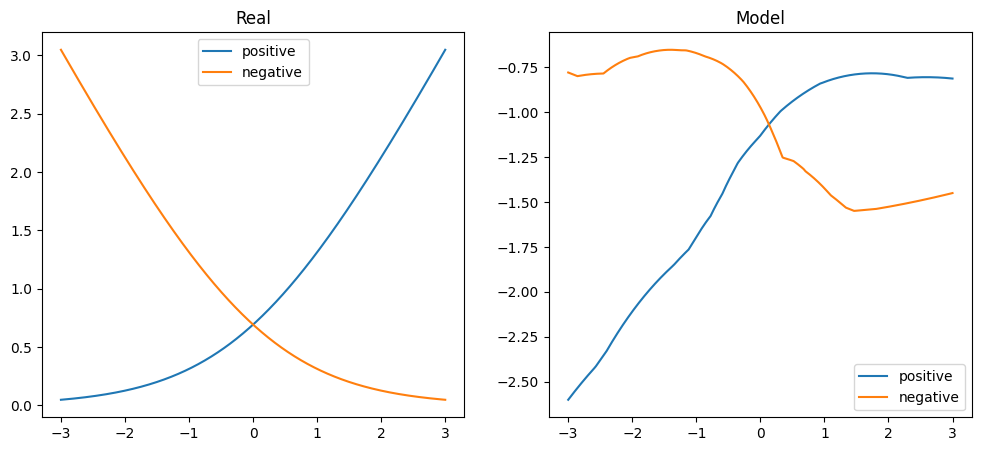

In [22]:
N = 1000

x = np.linspace(-3, 3, N).reshape((N, 1, 1))

pos, y_pos = prepare_data(x, np.ones((N, 1, 1)), mode)
s_pos = -ranker(torch.from_numpy(pos.astype("float32"))).detach().numpy()

neg, y_neg = prepare_data(x, np.zeros((N, 1, 1)), mode)
s_neg = -ranker(torch.from_numpy(neg.astype("float32"))).detach().numpy()

figure, axes = plt.subplots(ncols=2, figsize=(12, 5))
axes[1].plot(x.squeeze((1, 2)), s_pos.squeeze((1, 2)), label="positive")
axes[1].plot(x.squeeze((1, 2)), s_neg.squeeze((1, 2)), label="negative")
axes[1].legend()
axes[1].set_title("Model")

axes[0].plot(x.squeeze((1, 2)), y_pos.squeeze((1, 2)), label="positive")
axes[0].plot(x.squeeze((1, 2)), y_neg.squeeze((1, 2)), label="negative")
axes[0].legend()
axes[0].set_title("Real")

pass

In [23]:
N = 10000
x, y = generate_data(k, N, mode)
scores = ranker(torch.from_numpy(x.astype("float32"))).detach().numpy()

stats = np.zeros((2, k, 2*k-1))
for i in range(N):
    flag_i = int(x[i, 0, 1])
    y_i = y[i].squeeze()
    score_i = scores[i].squeeze()

    true_sort = np.argsort(-y_i)
    pred_sort = np.argsort(score_i)

    for j in range(k):
        delta = np.where(pred_sort == true_sort[j])[0][0] - j
        stats[flag_i, j, delta + k - 1] += 1

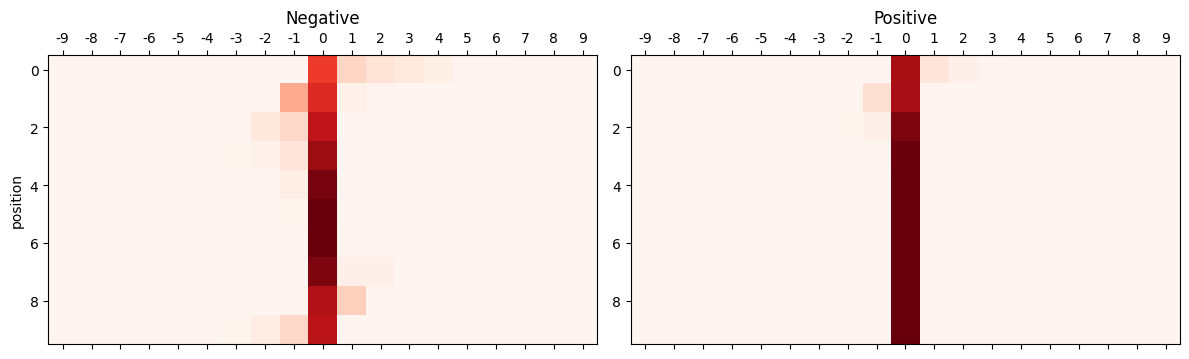

In [24]:
figure, axes = plt.subplots(ncols=2, figsize=(12, 5))

axes[0].matshow(stats[0], cmap=plt.cm.Reds)
axes[0].set_xticks(np.arange(2*k - 1), np.arange(2*k - 1) - k + 1)
axes[0].set_title("Negative")
axes[0].set_ylabel("position")

axes[1].matshow(stats[1], cmap=plt.cm.Reds)
axes[1].set_xticks(np.arange(2*k - 1), np.arange(2*k - 1) - k + 1)
axes[1].set_title("Positive")

figure.tight_layout()

pass